# Overview


The program will be implemented as a python program and will leverage a variety of libraries required to address our cancer detection ML models and analysis:
* InceptionV3
* Keras (Tensorflow)
* Tensorflow dataset module
* Dense
* Model
* Global Average Pooling (GAP)

The GAP technique in CNN(Convolutional Neural Networks) is of interest to improve on standards. The GAP has some advantages to consider over fully connected layers as follows:
Reduction of data can be reduced through flattening out some intermediate nodes to be trained. As a result the training model time to complete should improve.
Reduction of data also has the benefit of minimizing over fitting versus fully connected layers.

To simplify our processing and data cleaning, we will use curated datasets. We will use PatchCamelyon for our analysis.
The PatchCamelyon benchmark is a new and challenging image classification dataset. It consists of 327.680 color images (96 x 96px) extracted from histopathologic scans of lymph node sections.(Veeler, 2018)



The process from steps 4-6 will continue to iterate based on the Models predictive performance evaluation to detect cancer from the curated images.
How we will measure success:
As the datasets are well known, our success can be compared to various benchmarks such as those referenced in PatchCamelyon. The paper which utilizes the PatchCamelyon dataset provides accuracy rates, areas under the curve, negative log likelihood, and different hyper parameters used [Veeler].


## Goal

Our novel goal is to develop an AI learning algorithm using GAP to enhance the efficiency of cancer diagnosis through digital imaging. We want to improve upon the techniques we found in our research. CNN techniques tend to use large amounts of memory and tend to not be time-efficient due to the large number of parameters. The purpose of GAP is to reduce the number of layers used. [Hsiao]. This will help address some additional improvements to the accuracy of the model and potentially additional layers to remove based on our analysis. If time permits, we will add a stretch goal to consider applying GAN (Generative Adversarial Networks) to improve on our ML model performance[Grnarova et al.].

Let's begin with our initial Class creation.
This class will provide all the required interfaces to run and validate image cancer detection

# High Level Description of our process

We will pre-train the Inception V3 model and freeze all layers up to the bottleneck. Train the network and test it's accuracy and loss.

Then unfreeze the data and compare results.

Once complete with evaluating with and without updated weights for the model, we retrain the model using data augmentation where we will vertically flip the images and compare performance of accuracy and loss.

Finally we will reevaluate our model using data augmentation techniques and compare results.

In [1]:
# Initial imports needed for the image model performance testing through tensorflow
from pprint import pprint
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds


In [319]:
import os
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Input, Dense, GlobalMaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential

In [3]:
import numpy as np
import matplotlib.pyplot as plt


In [320]:
class ImageDetection:
    def __init__(self, batch_size, ds_train, ds_val, ds_test, ds_info):
        self.batch_size = batch_size
        self.ds_train = ds_train
        self.ds_validation = ds_val
        self.ds_test = ds_test
        self.ds_info = ds_info
        
    # Apply all metrics to our training analysis 
    METRICS = [
        keras.metrics.TruePositives(name='tp'), 
        keras.metrics.FalsePositives(name='fp'), 
        keras.metrics.TrueNegatives(name='tn'), 
        keras.metrics.FalseNegatives(name='fn'), 
        keras.metrics.BinaryAccuracy(name='accuracy'), 
        keras.metrics.Precision(name='precision'), 
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc'),
        keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
    ]
    
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    def plotAccuracy(self, model):
        acc = model.history['accuracy']
        val_acc = model.history['val_accuracy']
        loss = model.history['loss']
        val_loss = model.history['val_loss']

        plt.figure(figsize=(8, 8))
        plt.subplot(2, 1, 1)
        plt.plot(acc, label='Training Accuracy')
        plt.plot(val_acc, label='Validation Accuracy')
        plt.legend(loc='lower center')
        plt.ylabel('Accuracy')
        plt.ylim([min(plt.ylim()),1])
        plt.title('Model Accuracy')

        plt.subplot(2, 1, 2)
        plt.plot(loss, label='Training Loss')
        plt.plot(val_loss, label='Validation Loss')
        plt.legend(loc='upper center')
        plt.ylabel('Cross Entropy')
        plt.ylim([0,1.0])
        plt.title('Model Loss')
        plt.xlabel('epoch')
        plt.show()
        
    # Directly referencing 
    # https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
    def plotMetrics(self, history):
      metrics = ['loss', 'prc', 'precision', 'recall']
      fig=plt.figure(figsize=(10,6))
      for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=self.colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=self.colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
          plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
          plt.ylim([0.8,1])
        else:
          plt.ylim([0,1])

        #plt.legend()
        plt.tight_layout()

    def displayPerformance(self, history):
        #train and validation
        print('Recall: train={r} validate={vr}'.format(
            r=round(np.max(history.history['recall']),2),
            vr=round(np.max(history.history['val_recall']),2)
        ))
        print('accuracy: train={a} validate={va}'.format(
            a=round(np.max(history.history['accuracy']),2),
            va=round(np.max(history.history['val_accuracy']),2)
        ))
        print('precision: train={p} validate={vp}'.format(
            p=round(np.max(history.history['precision']),2),
            vp=round(np.max(history.history['val_precision']),2)
        ))

    def displayPerformanceLastEpoch(self, history):
        #train and validation
        print('Recall: train={r} validate={vr}'.format(
            r=round(history.history['recall'][4],2),
            vr=round(history.history['val_recall'][4],2)
        ))
        print('accuracy: train={a} validate={va}'.format(
            a=round(history.history['accuracy'][4],2),
            va=round(history.history['val_accuracy'][4],2)
        ))
        print('precision: train={p} validate={vp}'.format(
            p=round(history.history['precision'][4],2),
            vp=round(history.history['val_precision'][4],2)
        ))
        
    def displayImageInformation(self):
        print(ds_info)
    
    def displayImageShape(self):
        pprint(ds_info.features['image'])
        
    def displayFeatures(self):
        pprint(ds_info.features)
        
    def displayImages(self, rows, cols):
        fig = tfds.show_examples(ds_train, ds_info, rows=rows, cols=cols)
        
    def normalize_img(self, image, label):
      return tf.cast(image, tf.float16)/255.0, label

    # Augmentation did not improve the performance.
    # So, return the normal image for now.
    def augment(self, image_label, seed):
      image, label = image_label
      image, label = self.normalize_img(image, label)
      return image, label

    def setupModelForTraining(self):
        AUTOTUNE = tf.data.AUTOTUNE
        BATCH_SIZE = self.batch_size
        
        counter = tf.data.experimental.Counter()
        self.ds_train = tf.data.Dataset.zip((self.ds_train, (counter, counter)))
        
        self.ds_train = self.ds_train.map(self.augment, num_parallel_calls = AUTOTUNE)

        # It's recommended to cache after map function to keep working set data in memory
        self.ds_train = self.ds_train.cache()
        self.ds_train = self.ds_train.shuffle(self.ds_info.splits["train"].num_examples)
        # Let's Shuffle data randomly in in batch sizes
        self.ds_train = self.ds_train.batch(BATCH_SIZE)
        self.ds_train = self.ds_train.prefetch(AUTOTUNE)
        
        self.ds_validation = self.ds_validation.map(self.normalize_img, num_parallel_calls = AUTOTUNE)
        self.ds_validation = self.ds_validation.batch(BATCH_SIZE)
        self.ds_validation = self.ds_validation.prefetch(AUTOTUNE)
        
        self.ds_test = self.ds_test.map(self.normalize_img, num_parallel_calls = AUTOTUNE)
        self.ds_test = self.ds_test.batch(BATCH_SIZE)
        self.ds_test = self.ds_test.prefetch(AUTOTUNE)
        
    def createModel(self, image_size = 96, GAP=1):
      inception = InceptionV3(weights = 'imagenet',
                              include_top = False,
                              input_shape = (image_size, image_size, 3))
    
        # We freeze the network base created from the previous step and 
        # apply a feature extractor and add a classifier on top of it by 
        # training the top-level classifier.
      for layer in inception.layers:
        layer.trainable = False

      model = Sequential()
      model.add(inception)
      if GAP:
        model.add(GlobalAveragePooling2D())
      else:
        model.add(GlobalMaxPooling2D())
            

      input = Input(shape=(image_size, image_size, 3))

      encoded = model(input)

      dense1 = Dense(256, activation='relu')(encoded)
      batch_normalization1 = BatchNormalization()(dense1)
      drop_layer = tf.keras.layers.Dropout(0.7)(batch_normalization1)
      dense2 = Dense(128, activation='relu')(drop_layer)
      batch_normalization2 = BatchNormalization()(dense2)
      drop_layer2 = tf.keras.layers.Dropout(0.7)(batch_normalization2)

      output = Dense(1, activation='sigmoid')(drop_layer2)
      model = Model(inputs=[input], outputs=output)

      return model

    def compileModel(self, model):
        return model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='binary_crossentropy',
              metrics=self.METRICS)
    
    def runModel(self, model, cb, bs, e, verbosity):
        return model.fit(self.ds_train,
          batch_size = bs, 
          epochs = e,
          verbose = verbosity,
          validation_data = (self.ds_validation),
          callbacks = cb
          )


# Main program

## Load the data into the dataset

In [243]:
(ds_train, ds_validation, ds_test), ds_info = tfds.load(
    "patch_camelyon",
    split = ["train", "validation", "test"], 
    shuffle_files = True,
    as_supervised = True,
    with_info = True,
   # batch_size=32,
    data_dir='/Users/jeffbloom13/WPI/CS534-AI/Project')
    #data_dir='/Users/jeffbloom13/WPI/CS534-AI/Project', try_gcs=False)

In [246]:
Img = ImageDetection(64, ds_train,ds_validation,ds_test,ds_info)

In [247]:
Img.displayImageInformation()

tfds.core.DatasetInfo(
    name='patch_camelyon',
    full_name='patch_camelyon/2.0.0',
    description="""
    The PatchCamelyon benchmark is a new and challenging image classification
    dataset. It consists of 327.680 color images (96 x 96px) extracted from
    histopathologic scans of lymph node sections. Each image is annoted with a
    binary label indicating presence of metastatic tissue. PCam provides a new
    benchmark for machine learning models: bigger than CIFAR10, smaller than
    Imagenet, trainable on a single GPU.
    """,
    homepage='https://patchcamelyon.grand-challenge.org/',
    data_path='/Users/jeffbloom13/WPI/CS534-AI/Project/patch_camelyon/2.0.0',
    download_size=7.48 GiB,
    dataset_size=7.06 GiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(96, 96, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    split

In [222]:
Img.displayImageShape()

Image(shape=(96, 96, 3), dtype=tf.uint8)


In [223]:
Img.displayFeatures()

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(96, 96, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


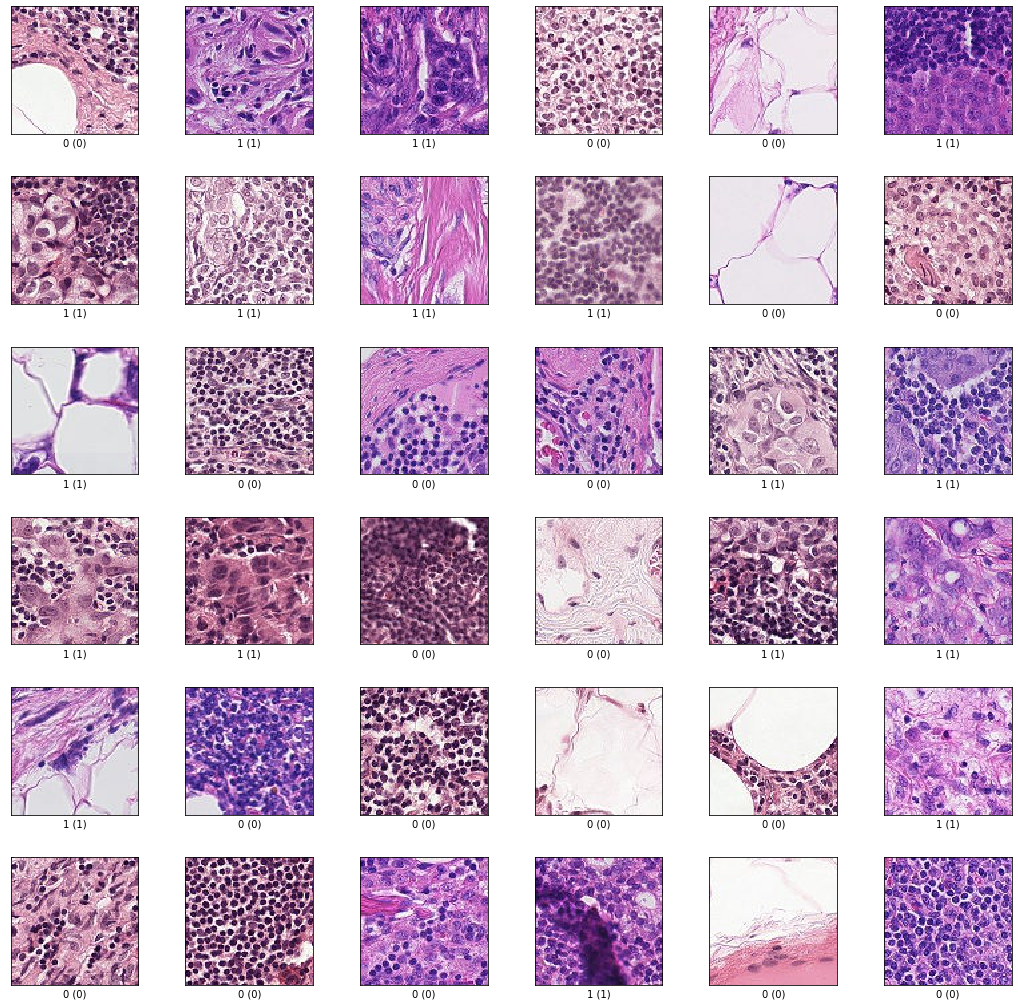

In [224]:
# Display some inages 6 columns and 6 rows
rows=6
columns=6
Img.displayImages(rows, columns)


In [225]:
Img.setupModelForTraining()

In [226]:
model = Img.createModel()
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 96, 96, 3)]       0         
_________________________________________________________________
sequential_4 (Sequential)    (None, 2048)              21802784  
_________________________________________________________________
dense_12 (Dense)             (None, 256)               524544    
_________________________________________________________________
batch_normalization_478 (Bat (None, 256)               1024      
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_479 (Bat (None, 128)               512 

In [227]:
Img.compileModel(model)

In [228]:
callbackEarlyStopLoss = [tf.keras.callbacks.EarlyStopping(monitor="val_loss" , patience=5 , verbose=1)]

In [229]:
pprint('Trainable variables => {}'.format(len(model.trainable_variables)))

'Trainable variables => 10'


In [230]:
print("Base model layers => {} " .format(len(model.layers)))


Base model layers => 9 


In [231]:
verbosity = 1
epochs = 5
#history = Img.runModel(model, callbackEarlyStopLoss, BATCH_SIZE, epochs, verbosity)
history = Img.runModel(model, callbackEarlyStopLoss, 64, epochs, verbosity)


Epoch 1/5
4096/4096 [==============================] - 1414s 325ms/step - loss: 1.0006 - tp: 38990.5755 - fp: 25192.5148 - tn: 40437.8653 - fn: 26515.0288 - accuracy: 0.5845 - precision: 0.5856 - recall: 0.5744 - auc: 0.6162 - prc: 0.6035 - val_loss: 0.5063 - val_tp: 10888.0000 - val_fp: 2395.0000 - val_tn: 14004.0000 - val_fn: 5481.0000 - val_accuracy: 0.7596 - val_precision: 0.8197 - val_recall: 0.6652 - val_auc: 0.8468 - val_prc: 0.8483
Epoch 2/5
4096/4096 [==============================] - 1303s 318ms/step - loss: 0.7224 - tp: 45467.9497 - fp: 18716.5306 - tn: 46834.2565 - fn: 20117.2475 - accuracy: 0.7007 - precision: 0.7048 - recall: 0.6902 - auc: 0.7686 - prc: 0.7642 - val_loss: 0.4783 - val_tp: 11384.0000 - val_fp: 2465.0000 - val_tn: 13934.0000 - val_fn: 4985.0000 - val_accuracy: 0.7726 - val_precision: 0.8220 - val_recall: 0.6955 - val_auc: 0.8632 - val_prc: 0.8642
Epoch 3/5
4096/4096 [==============================] - 1237s 302ms/step - loss: 0.6438 - tp: 47059.9697 - fp: 17

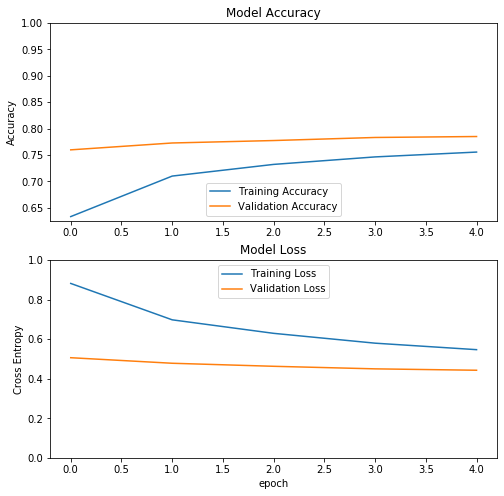

In [232]:
# let's plot our latest performance
# This model had no weights turned on, using Global Average Pooling
Img.plotAccuracy(history)

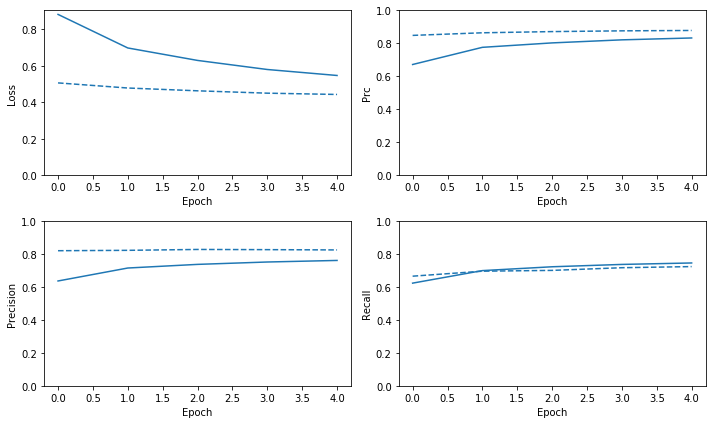

In [237]:
Img.plotMetrics(history)

In [238]:
Img.displayPerformance(history)

Recall: train=0.75 validate=0.72
accuracy: train=0.76 validate=0.78
precision: train=0.76 validate=0.83


In [239]:
Img.displayPerformanceLastEpoch(history)

Recall: train=0.75 validate=0.72
accuracy: train=0.76 validate=0.78
precision: train=0.76 validate=0.82


In [287]:
# Re run training with lower batch size = 8
#Img = ImageDetection(8, ds_train,ds_validation,ds_test,ds_info)

#verbosity = 1
#epochs = 5
#batch_size=8
#history = Img.runModel(model, callbackEarlyStopLoss, batch_size, epochs, verbosity)


In [280]:
(ds_train, ds_validation, ds_test), ds_info = tfds.load(
    "patch_camelyon",
    split = ["train", "validation", "test"], 
    shuffle_files = True,
    as_supervised = True,
    with_info = True,
    #batch_size=16,
    data_dir='/Users/jeffbloom13/WPI/CS534-AI/Project')
    #data_dir='/Users/jeffbloom13/WPI/CS534-AI/Project', try_gcs=False)

In [281]:
Img2 = ImageDetection(32, ds_train,ds_validation,ds_test,ds_info)

In [282]:
Img2.setupModelForTraining()


In [283]:
model2 = Img2.createModel()
model2.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 96, 96, 3)]       0         
_________________________________________________________________
sequential_8 (Sequential)    (None, 2048)              21802784  
_________________________________________________________________
dense_24 (Dense)             (None, 256)               524544    
_________________________________________________________________
batch_normalization_862 (Bat (None, 256)               1024      
_________________________________________________________________
dropout_16 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_863 (Bat (None, 128)               512 

In [284]:
Img2.compileModel(model2)

In [286]:
history_8 = Img2.runModel(model2, callbackEarlyStopLoss, 32, epochs, verbosity)


Epoch 1/5
8192/8192 [==============================] - 1261s 154ms/step - loss: 0.6675 - tp: 94981.0000 - fp: 37004.0000 - tn: 94068.0000 - fn: 36091.0000 - accuracy: 0.7212 - precision: 0.7196 - recall: 0.7246 - auc: 0.7927 - prc: 0.7857 - val_loss: 0.4569 - val_tp: 12552.0000 - val_fp: 3140.0000 - val_tn: 13259.0000 - val_fn: 3817.0000 - val_accuracy: 0.7877 - val_precision: 0.7999 - val_recall: 0.7668 - val_auc: 0.8703 - val_prc: 0.8696
Epoch 2/5
8192/8192 [==============================] - 1273s 155ms/step - loss: 0.5956 - tp: 97556.0000 - fp: 34363.0000 - tn: 96709.0000 - fn: 33516.0000 - accuracy: 0.7411 - precision: 0.7395 - recall: 0.7443 - auc: 0.8156 - prc: 0.8109 - val_loss: 0.4463 - val_tp: 12479.0000 - val_fp: 2973.0000 - val_tn: 13426.0000 - val_fn: 3890.0000 - val_accuracy: 0.7906 - val_precision: 0.8076 - val_recall: 0.7624 - val_auc: 0.8747 - val_prc: 0.8750
Epoch 3/5
8192/8192 [==============================] - 1301s 159ms/step - loss: 0.5486 - tp: 99045.0000 - fp: 32

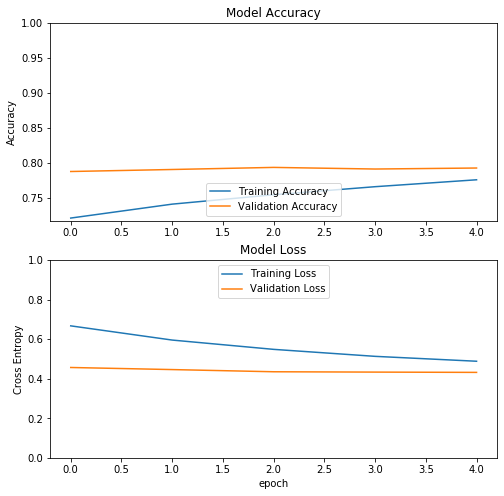

In [288]:
Img2.plotAccuracy(history_8)

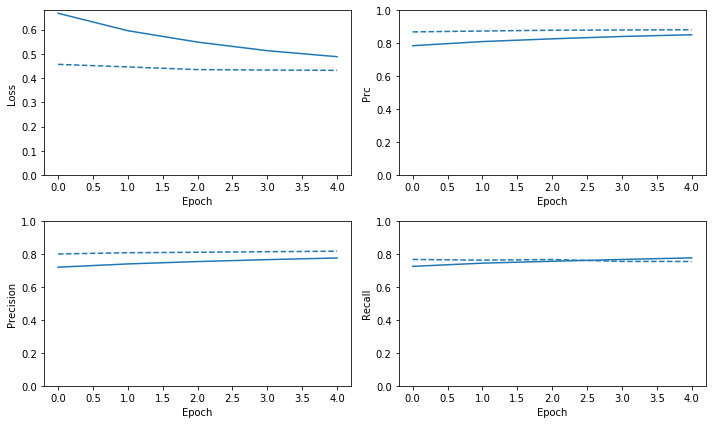

In [292]:
Img2.plotMetrics(history_8)

In [289]:
Img2.displayPerformance(history_8)

Recall: train=0.78 validate=0.77
accuracy: train=0.78 validate=0.79
precision: train=0.78 validate=0.82


In [290]:
Img2.displayPerformanceLastEpoch(history_8)

Recall: train=0.78 validate=0.75
accuracy: train=0.78 validate=0.79
precision: train=0.78 validate=0.82


# Now to update weights and unfreeze



In [293]:
# Re run with training model using weights within a subset of parameters.
print("Base model layers => {} " .format(len(model2.layers)))

Base model layers => 9 


In [295]:
# Fine tune from this layer onwards
tuneLayers = 5

# Freeze all the layers before the fine tuning layer
# Loop thru and set trainable to false for all layers before tuning
for layer in model2.layers[:tuneLayers]:
  layer.trainable =  False

In [296]:
ImgW = ImageDetection(32, ds_train,ds_validation,ds_test,ds_info)

In [297]:
ImgW.setupModelForTraining()


In [298]:
modelW = ImgW.createModel()
modelW.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 96, 96, 3)]       0         
_________________________________________________________________
sequential_9 (Sequential)    (None, 2048)              21802784  
_________________________________________________________________
dense_27 (Dense)             (None, 256)               524544    
_________________________________________________________________
batch_normalization_958 (Bat (None, 256)               1024      
_________________________________________________________________
dropout_18 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_959 (Bat (None, 128)               512 

In [299]:
ImgW.compileModel(modelW)

In [300]:
historyW = ImgW.runModel(modelW, callbackEarlyStopLoss, 32, epochs, verbosity)


Epoch 1/5
8192/8192 [==============================] - 1409s 163ms/step - loss: 0.9680 - tp: 53128.3685 - fp: 28446.7333 - tn: 53544.2037 - fn: 28752.6906 - accuracy: 0.6553 - precision: 0.6570 - recall: 0.6501 - auc: 0.7052 - prc: 0.6844 - val_loss: 0.4926 - val_tp: 12566.0000 - val_fp: 3661.0000 - val_tn: 12738.0000 - val_fn: 3803.0000 - val_accuracy: 0.7722 - val_precision: 0.7744 - val_recall: 0.7677 - val_auc: 0.8490 - val_prc: 0.8520
Epoch 2/5
8192/8192 [==============================] - 1325s 162ms/step - loss: 0.6901 - tp: 46965.0696 - fp: 19042.3292 - tn: 46404.7860 - fn: 18691.8113 - accuracy: 0.7100 - precision: 0.7099 - recall: 0.7132 - auc: 0.7784 - prc: 0.7710 - val_loss: 0.4629 - val_tp: 12698.0000 - val_fp: 3356.0000 - val_tn: 13043.0000 - val_fn: 3671.0000 - val_accuracy: 0.7856 - val_precision: 0.7910 - val_recall: 0.7757 - val_auc: 0.8663 - val_prc: 0.8685
Epoch 3/5
8192/8192 [==============================] - 1320s 161ms/step - loss: 0.6055 - tp: 48455.8714 - fp: 17

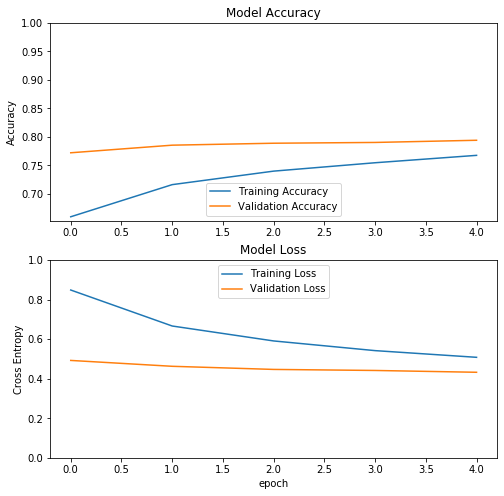

In [301]:
ImgW.plotAccuracy(historyW)

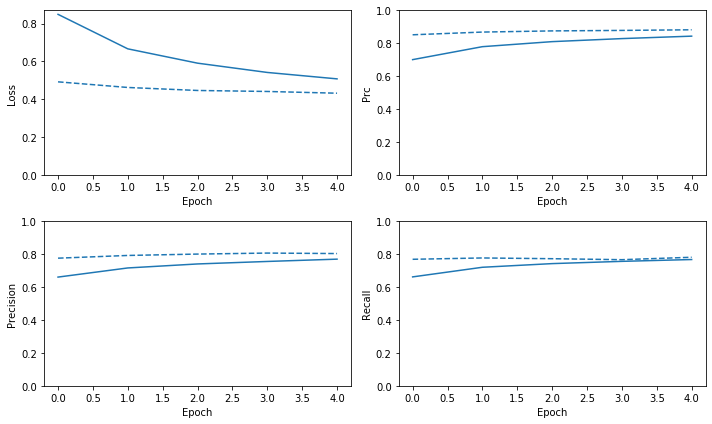

In [302]:
ImgW.plotMetrics(historyW)

In [303]:
ImgW.displayPerformance(historyW)

Recall: train=0.77 validate=0.78
accuracy: train=0.77 validate=0.79
precision: train=0.77 validate=0.81


In [304]:
ImgW.displayPerformanceLastEpoch(historyW)

Recall: train=0.77 validate=0.78
accuracy: train=0.77 validate=0.79
precision: train=0.77 validate=0.8


# Next let's compare against Max Pooling versus Global Avg Pooling.

In [321]:
(ds_train, ds_validation, ds_test), ds_info = tfds.load(
    "patch_camelyon",
    split = ["train", "validation", "test"], 
    shuffle_files = True,
    as_supervised = True,
    with_info = True,
    #batch_size=16,
    data_dir='/Users/jeffbloom13/WPI/CS534-AI/Project')


In [322]:
ImgMax = ImageDetection(32, ds_train,ds_validation,ds_test,ds_info)

In [323]:
ImgMax.setupModelForTraining()

In [324]:
modelMax = ImgMax.createModel(GAP=0)
modelMax.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, 96, 96, 3)]       0         
_________________________________________________________________
sequential_12 (Sequential)   (None, 2048)              21802784  
_________________________________________________________________
dense_33 (Dense)             (None, 256)               524544    
_________________________________________________________________
batch_normalization_1244 (Ba (None, 256)               1024      
_________________________________________________________________
dropout_22 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_1245 (Ba (None, 128)               512

In [325]:
ImgMax.compileModel(modelMax)

In [326]:
historyMax = ImgMax.runModel(modelMax, callbackEarlyStopLoss, 32, epochs, verbosity)


Epoch 1/5
8192/8192 [==============================] - 1428s 166ms/step - loss: 0.9578 - tp: 39204.7469 - fp: 24353.1030 - tn: 41199.9384 - fn: 26346.2079 - accuracy: 0.5929 - precision: 0.5961 - recall: 0.5771 - auc: 0.6304 - prc: 0.6225 - val_loss: 0.5064 - val_tp: 11008.0000 - val_fp: 2442.0000 - val_tn: 13957.0000 - val_fn: 5361.0000 - val_accuracy: 0.7619 - val_precision: 0.8184 - val_recall: 0.6725 - val_auc: 0.8468 - val_prc: 0.8489
Epoch 2/5
8192/8192 [==============================] - 1322s 161ms/step - loss: 0.6904 - tp: 45899.7011 - fp: 18209.2372 - tn: 47343.9430 - fn: 19651.1149 - accuracy: 0.7087 - precision: 0.7133 - recall: 0.6983 - auc: 0.7766 - prc: 0.7730 - val_loss: 0.4764 - val_tp: 11409.0000 - val_fp: 2375.0000 - val_tn: 14024.0000 - val_fn: 4960.0000 - val_accuracy: 0.7762 - val_precision: 0.8277 - val_recall: 0.6970 - val_auc: 0.8637 - val_prc: 0.8653
Epoch 3/5
8192/8192 [==============================] - 1326s 162ms/step - loss: 0.6064 - tp: 47537.1487 - fp: 16

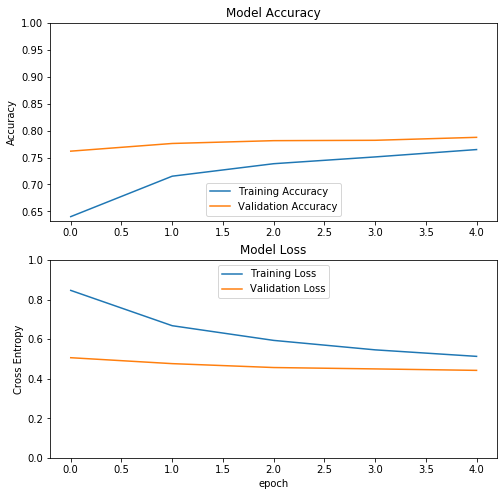

In [327]:
ImgMax.plotAccuracy(historyMax)

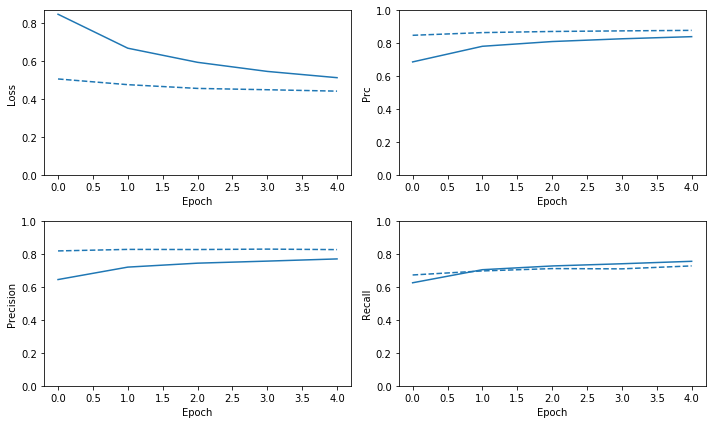

In [328]:
ImgMax.plotMetrics(historyMax)

In [329]:
ImgMax.displayPerformance(historyMax)

Recall: train=0.76 validate=0.73
accuracy: train=0.76 validate=0.79
precision: train=0.77 validate=0.83


In [330]:
ImgMax.displayPerformanceLastEpoch(historyMax)

Recall: train=0.76 validate=0.73
accuracy: train=0.76 validate=0.79
precision: train=0.77 validate=0.83
